In [1]:
#import libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
from matplotlib import pyplot as plt 
import matplotlib
#Options
params = {'font.size' : 14,
          'axes.labelsize': 14,               # -> axis labels
          'legend.fontsize': 14,              # -> legends
          'font.family': 'sans-serif',
          'font.sans-serif': "Comic Sans MS",
          'font.weight': 'bold',
          "axes.labelweight": "bold",
          "axes.titlesize": "medium",
          "axes.titleweight": "bold",
          }
plt.rcParams.update(params) 


import random
import pickle as pkls
import pandas as pd
import seaborn as sns

#local files being imported
import sys
sys.path.insert(0, '../src')
import platform_opt
from players import *
import sims
import sims_copy
from statistics import variance
#Note: when indexed as a list: group $A$ is 0, group $B$ is 1.
#      when indexed as a dict: group $A$ is -1, group $B$ is 1.

In [2]:
# SIMULATION PARAMETERS AGNOSTIC TO DATA
T = 10                 # max number of timesteps
M = 100000            # size of unit mass

#load parameters from dataset
dataset_name = 'twitter_abortion'
pi,beta_dist,P,v,c,q = sims.get_params(dataset_name)

Don't run this next cell if you already know what the theta params are

In [3]:
#how to show articles at timestep 1
#epsilon for additive constraints (difference in expected exposure bounded by epsilon)
epsilon = 0.25

#params for ratio constraints
delta_low = 0.25
delta_high = 2
    
theta_additive = platform_opt.opt('additive',pi, q, T, c,v,beta_dist,epsilon=epsilon, exposure_e=0.05) #constrained with exposure equality
theta_opt = platform_opt.opt('unconstrained', pi, q, T, c,v,beta_dist, exposure_e = 0.05) #unconstrained to optimize clicks
theta_ratio = platform_opt.opt('ratio',pi, q, T, c,v,beta_dist,delta_low=delta_low, delta_high=delta_high, exposure_e=0.05) #constrained with exposure equality

#theta_opt = {1:1., -1:0.}
theta_half = {1: 0.5, -1: 0.5}

print(theta_additive)
print(theta_opt)
print(theta_ratio)

{-1: 0.05, 1: 0.22694132943125175}
{-1: 0.05, 1: 0.95}
{-1: 0.08346568442898067, 1: 0.9499999999999996}


Run this if loading theta from previous runs.

In [4]:
#since the optimization in the following cell only needs to be run once per set of parameters

# dataset = 'twitter_abortion', delta_low = 0.25, delta_high=2, additive epsilon = 0.25, exposure_e = 0.05, T = 10, M = 100000 c_{gs} = 1, v_{g,s} = 2000/200
theta_additive = {-1: 0.049999999961021876, 1: 0.22694132946782486}
theta_half = {1: 0.5, -1: 0.5}
theta_opt = {-1: 0.05000000309726387, 1: 0.9499999982820164}
theta_ratio = {-1: 0.08346568445886182, 1: 0.9500000000344594}



In [5]:
trials_to_run = {'half':theta_half, 'opt':theta_opt, 'ratio':theta_ratio} #'additive':theta_additive
num_trials = 25

given number of trials and which types of interventions we want to test, returns the outputs 

In [6]:
trials = [sims.runModel_samepop(T, pi, M, P, beta_dist, v,c,q, trials_to_run) for ix in range(num_trials)]
avg = sims.average_dfs(trials) #dict of dataframes

new way of saving the trials.  trials is a list of dicts of dataframes; dicts indexed by theta_type, and dataframes have number of players, shown, click, and share

In [7]:
sims.saveRuns(trials, '../same_init_runs/' + str(dataset_name) + '/trials.pkl')
sims.saveRuns(avg, '../same_init_runs/' + str(dataset_name) + '/averages.pkl')

new way to unpickle data

In [8]:
trials = sims.loadRuns('../same_init_runs/' + str(dataset_name) + '/trials.pkl') #path not right
avg = sims.loadRuns('../same_init_runs/' + str(dataset_name) + '/averages.pkl')


In [9]:
#average intergroup exposure and share
#normalized by number of impressions/clicks in model
#higher is better here

print('Intergroup exposure')
for theta_type in trials_to_run.keys():
    print(theta_type)
    print(np.sum([avg[theta_type]['shown'][i][(1,-1)] for i in range(len(avg[theta_type]['shown'].index))]))
    print(np.sum([avg[theta_type]['shown'][i][(-1,1)] for i in range(len(avg[theta_type]['shown'].index))]))
    
print('\nIntergroup shares')
for theta_type in trials_to_run.keys():
    print(theta_type)
    print(np.sum([avg[theta_type]['share'][i][(1,-1)] for i in range(len(avg[theta_type]['share'].index))]))
    print(np.sum([avg[theta_type]['share'][i][(-1,1)] for i in range(len(avg[theta_type]['share'].index))]))
    


Intergroup exposure
half
19075.840000000004
32177.440000000002
opt
2528.96
4076.36
ratio
2538.2799999999997
6134.919999999999

Intergroup shares
half
629.28
124.04
opt
78.55999999999999
42.28
ratio
78.16
52.760000000000005


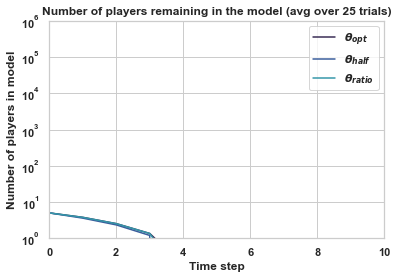

In [10]:
num_trials = len(trials)
sns.set(style="whitegrid")

avg_opt = avg['opt']
avg_half = avg['half']
avg_ratio = avg['ratio']
# avg_additive = avg['additive']

mk=sns.color_palette('mako', n_colors=4)

fig, ax = plt.subplots()
# Set the scale of the x-and y-axes
ax.set(xlabel='Time step', yscale="log", ylim=(1,10e5 +1), xlim=(0, T))
   
sns.lineplot(data=avg_opt, x=range(T), y='players_list', label='$\\theta_{opt}$', color=mk[0])
sns.lineplot(data=avg_half, x=range(T), y='players_list', label='$\\theta_{half}$', color=mk[1])
sns.lineplot(data=avg_ratio, x=range(T), y='players_list', label='$\\theta_{ratio}$', color=mk[2])
#sns.lineplot(data=avg_additive, x=range(T), y='players_list',color=mk[3])

ax.set(ylabel='Number of players in model', title = "Number of players remaining in the model (avg over %i trials)" % (num_trials))
plt.savefig('../figures/' + str(dataset_name) + '_num_players_in_model.pdf')
plt.show()

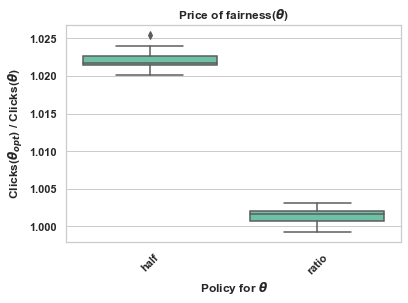

In [11]:
sns.set(style="whitegrid")
mk=sns.color_palette('mako', n_colors=4)

pof = {}
for theta_type in trials_to_run.keys():
    pof[theta_type] = [(trials[i]['opt']['players_list'].sum() / trials[i][theta_type]['players_list'].sum()) for i in range(num_trials)]

del(pof['opt'])
boxplot_pof = pd.DataFrame(data=pof)

fig, ax = plt.subplots()
sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_pof), color=mk[3])
ax.set(xlabel='Policy for $\\theta$', ylabel="Clicks($\\theta_{opt}$) / Clicks($\\theta$)", title='Price of fairness($\\theta$)')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.savefig('../figures/' + str(dataset_name) + '_pof_boxplot.pdf')

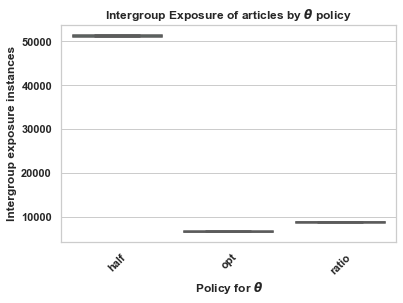

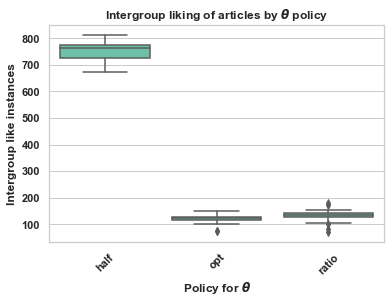

In [12]:
#calculate boxplot data
sns.set(style="whitegrid")
mk=sns.color_palette('mako', n_colors=4)

ig_shares = {}
ig_shown = {}
for theta_type in trials_to_run.keys():
    ig_shares[theta_type] = []
    ig_shown[theta_type] = []
    for i in range(num_trials):
        ig_shown[theta_type].append(np.sum([trials[i][theta_type]['shown'][j][(1,-1)] \
                                        + trials[i][theta_type]['shown'][j][(-1,1)] for j in range(T)]))
        ig_shares[theta_type].append(np.sum([trials[i][theta_type]['share'][j][(1,-1)] \
                                        + trials[i][theta_type]['share'][j][(-1,1)] for j in range(T)]))
    
boxplot_shown = pd.DataFrame(data=ig_shown)
boxplot_share = pd.DataFrame(data=ig_shares)
        
# plot data
fig, ax = plt.subplots()
sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_shown), color=mk[3])
ax.set(xlabel='Policy for $\\theta$', ylabel="Intergroup exposure instances", title='Intergroup Exposure of articles by $\\theta$ policy')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.savefig('../figures/' + str(dataset_name) + 'intergroup_exposure_boxplot.pdf')

fig, ax = plt.subplots()
sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_share), color=mk[3])
ax.set(xlabel='Policy for $\\theta$', ylabel="Intergroup like instances", title='Intergroup liking of articles by $\\theta$ policy')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.savefig('../figures/' + str(dataset_name) + 'intergroup_likes_boxplot.pdf')

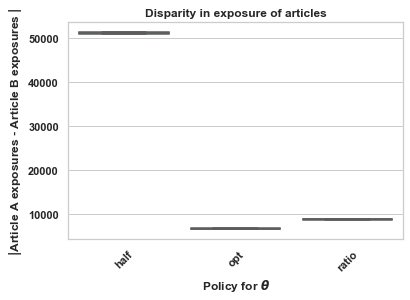

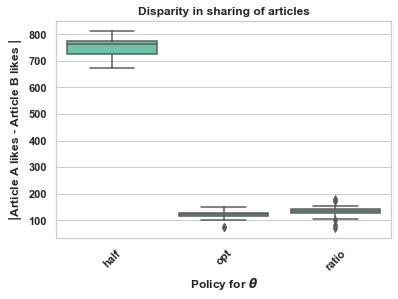

In [13]:
sns.set(style="whitegrid")
mk=sns.color_palette('mako', n_colors=4)

#calculate boxplots for difference in exposure 
#should be close to 0
# if np.abs removed, positive means article B shown more
#calculate boxplot data
ig_shares = {}
ig_shown = {}
for theta_type in trials_to_run.keys():
    ig_shares[theta_type] = []
    ig_shown[theta_type] = []
    for i in range(num_trials):
        ig_shown[theta_type].append(np.abs(np.sum([trials[i][theta_type]['shown'][j][(1,-1)] \
                                        - trials[i][theta_type]['shown'][j][(-1,1)] for j in range(T)])))
        ig_shares[theta_type].append(np.abs(np.sum([trials[i][theta_type]['share'][j][(1,-1)] \
                                        - trials[i][theta_type]['share'][j][(-1,1)] for j in range(T)])))
    
        
# plot data
fig, ax = plt.subplots()
sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_shown), color=mk[3])
ax.set(xlabel='Policy for $\\theta$', ylabel="$|$Article A exposures - Article B exposures $|$", title='Disparity in exposure of articles')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.savefig('../figures/' + str(dataset_name) + '_dis_exposure_boxplot.pdf')

fig, ax = plt.subplots()
sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_share), color=mk[3])
ax.set(xlabel='Policy for $\\theta$', ylabel="$|$Article A likes - Article B likes $|$", title='Disparity in sharing of articles')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.savefig('../figures/' + str(dataset_name) + '_dis_likes_boxplot.pdf')

### Set of experiments to understand impact of threshold epsilon.

In [14]:
T=10
theta_A = {}
theta_B = {}
delta_low = 0.25
delta_high= 2.
dataset_name = 'symmetric'
pi,beta_dist,P,v,c,q = sims.get_params(dataset_name)

for exp in [0., 0.01, 0.05, 0.1, 0.15, 0.2]:
    theta_fair = platform_opt.opt('ratio',pi, q, T, c,v,beta_dist,delta_low=delta_low, delta_high=delta_high, exposure_e=exp) #constrained with exposure equality 
    theta_A[exp] = theta_fair[1]
    theta_B[exp] = theta_fair[-1]
    print((theta_fair, exp))
    
    
list_A = sorted(theta_A.items()) # sorted by key, return a list of tuples
list_B = sorted(theta_B.items()) # sorted by key, return a list of tuples




({-1: 4.71546159300076e-31, 1: 0.9999999999999998}, 0.0)
({-1: 0.010000000000000004, 1: 0.9899999999999998}, 0.01)
({-1: 0.05000000000000002, 1: 0.9499999999999997}, 0.05)
({-1: 0.10000000000000003, 1: 0.8999999999999998}, 0.1)
({-1: 0.15000000000000002, 1: 0.8499999999999998}, 0.15)
({-1: 0.20000000000000007, 1: 0.8}, 0.2)


[(0.0, 0.9999999999999998), (0.01, 0.9899999999999998), (0.05, 0.9499999999999997), (0.1, 0.8999999999999998), (0.15, 0.8499999999999998), (0.2, 0.8)]


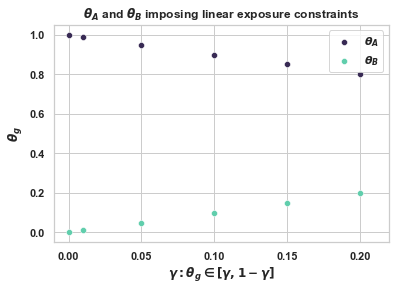

In [15]:
sns.set(style="whitegrid")
mk=sns.color_palette('mako', n_colors=4)

fig,ax = plt.subplots()

eps_A, thetaA = zip(*list_A) # unpack a list of pairs into two tuples
eps_B, thetaB = zip(*list_B) # unpack a list of pairs into two tuples

print(list_A)

sns.scatterplot(x=eps_A, y=thetaA, color=mk[0])
sns.scatterplot(x=eps_B, y=thetaB, color=mk[3])
ax.set(xlabel='$\\gamma : \\theta_g \\in [\\gamma, 1-\\gamma]$', ylabel='$\\theta_g$', xlim=(-0.01,0.22), ylim=(-0.05,1.05))
ax.set(title='$\\theta_A$ and $\\theta_B$ imposing linear exposure constraints')
ax.legend(['$\\theta_A$', '$\\theta_B$'])
plt.savefig('../figures/' + str(dataset_name) + '_linear_exposure_constraints.png')
plt.show()

In [16]:
sims.saveRuns((list_A, list_B), '../same_init_runs/' + str(dataset_name) + '_vary_linear_exposure.pkl')

In [17]:
list_A, list_B = sims.loadRuns('../same_init_runs/' + str(dataset_name) + '_vary_linear_exposure.pkl')

### Experiment with ratio constraint parameters

In [18]:
# I have tried something and I changed code everything and nothing was changing, until I realized, 
# ratio works if delta_low is btwn 0.1 and 0.3 and high is up to 2, meaning there 
# are different pairs of delta high and low that are not compartible.

In [19]:
T=10
dataset_name = 'symmetric'
pi,beta_dist,P,v,c,q = sims.get_params(dataset_name)
platform_opt.opt('ratio',pi, q, T, c,v,beta_dist,delta_low=0.25, delta_high=2.)

{-1: 4.71546159300076e-31, 1: 0.9999999999999998}

In [20]:
T=10
theta_A = {}
theta_B = {}
exposure_e = 0.05
for delta_low in [0.1, 0.15, 0.25,0.5]:
    for delta_high in [1.1, 1.5, 2., 2.5]:
        print((delta_low,delta_high))
        theta_ratio = platform_opt.opt('ratio',pi, q, T, c,v,beta_dist,delta_low=delta_low, delta_high=delta_high,exposure_e=0.01)
        theta_A[(delta_low, delta_high)] = theta_ratio[1]
        theta_B[(delta_low, delta_high)] = theta_ratio[-1]
    
list_A = sorted(theta_A.items()) # sorted by key, return a list of tuples
hold_A, thetaA = zip(*list_A) # unpack a list of pairs into two tuples
delta_low_A, delta_high_A = zip(*hold_A)

list_B = sorted(theta_B.items()) # sorted by key, return a list of tuples
hold_B, thetaB = zip(*list_B) # unpack a list of pairs into two tuples
delta_low_B, delta_high_B = zip(*hold_B)



(0.1, 1.1)
(0.1, 1.5)
(0.1, 2.0)
(0.1, 2.5)
(0.15, 1.1)
(0.15, 1.5)
(0.15, 2.0)
(0.15, 2.5)
(0.25, 1.1)
(0.25, 1.5)
(0.25, 2.0)
(0.25, 2.5)
(0.5, 1.1)
(0.5, 1.5)
(0.5, 2.0)
(0.5, 2.5)


       1.1   1.5   2.0   2.5
0.10  0.99  0.99  0.99  0.99
0.15  0.99  0.99  0.99  0.99
0.25  0.99  0.99  0.99  0.99
0.50  0.99  0.99  0.99  0.99


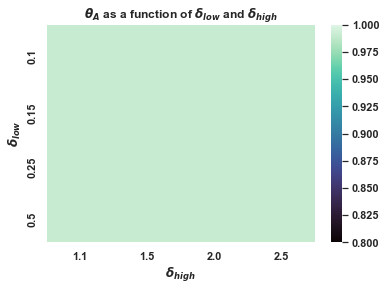

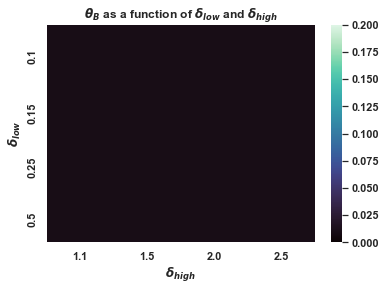

In [21]:
sns.set(style="whitegrid")
mk=sns.color_palette('mako', n_colors=4)

ser = pd.Series(list(theta_A.values()),
                  index=pd.MultiIndex.from_tuples(theta_A.keys()))
df = ser.unstack().fillna(0)

print(df)

ax = sns.heatmap(df,cmap='mako', vmin=0.8, vmax=1)
plt.title("$\\theta_A$ as a function of $\\delta_{low}$ and $\\delta_{high}$")
plt.xlabel("$\\delta_{high}$")
plt.ylabel("$\\delta_{low}$")
plt.savefig('../figures/' + str(dataset_name) +'_heatmap_theta_A_ratio_params.pdf')
plt.show()

sns.set(style="whitegrid")
ser = pd.Series(list(theta_B.values()),
                  index=pd.MultiIndex.from_tuples(theta_B.keys()))
df = ser.unstack().fillna(0)

ax = sns.heatmap(df,cmap='mako', vmin=0, vmax=.2)
plt.title("$\\theta_B$ as a function of $\\delta_{low}$ and $\\delta_{high}$")
plt.xlabel("$\\delta_{high}$")
plt.ylabel("$\\delta_{low}$")
plt.savefig('../figures/' + str(dataset_name) +'_heatmap_theta_B_ratio_params.pdf')
plt.show()

### heatmap varying homophily constraint

In [22]:
import numpy as np
import seaborn as sns
import pickle as pkl
import pandas as pd

#heatmap varying q_A and q_B
num_trials = 25
M = 100000


T = 5
add_epsilon = 0.05       
delta_low = 0.25
delta_high = 2.

dataset_name = 'symmetric'
pi,beta_dist,P,v,c,q = sims.get_params(dataset_name)


share_list = []
ig_share_list = [] #intergroup shares

st = 0.1
n = np.arange(0.5, 1.01, step=st).shape[0]
data = np.zeros(n)
ig_data = np.zeros(n)




for k,q_A in enumerate(np.arange(0.5, 1.01, step=st)):
    q = {-1: q_A, 1: q_A}
    theta_fair = platform_opt.opt('ratio',pi, q, T, c,v,beta_dist,delta_low=delta_low, delta_high=delta_high, exposure_e=0.0)
    for i in range(num_trials):
        players_in_model_fair, shown_d_fair, click_d_fair, share_d_fair = sims.runModel(theta_fair, T, pi, M, P, beta_dist, v,c,q)
        share_list.append(sum([share_d_fair[key] for key in share_d_fair.keys()]))
        ig_share_list.append(sum([share_d_fair[key] for key in share_d_fair.keys() if key[0] == -key[1]]))


    data[k] = np.mean(share_list)
    ig_data[k] = np.mean(ig_share_list)

df = pd.DataFrame({"Total Shares": data, "Intergroup Shares": ig_data, "$q_A = q_B$" : np.round(np.arange(0.5, 1.01, step=st), 2)})

In [23]:
sims.saveRuns(df, '../same_init_runs/' + str(dataset_name) + '_homophily_shares.pkl')

In [24]:
df = sims.loadRuns('../same_init_runs/' + str(dataset_name) + '_homophily_shares.pkl')

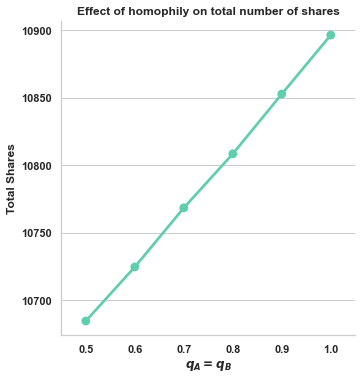

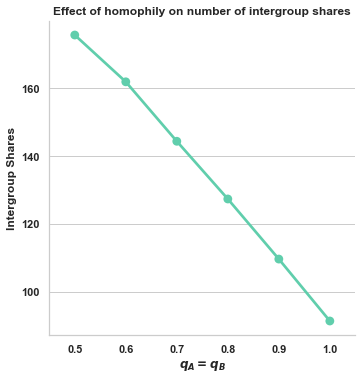

In [25]:
sns.set(style="whitegrid")
mk=sns.color_palette('mako', n_colors=4)


ax = sns.factorplot(data = df, x = "$q_A = q_B$", y = "Total Shares", log=True, color=mk[3])
plt.title("Effect of homophily on total number of shares")
plt.savefig('../figures/' + str(dataset_name) + '_homophily_shares.pdf')
plt.show()

ax = sns.factorplot(data = df, x = "$q_A = q_B$", y = "Intergroup Shares", log=True, color=mk[3])
plt.title("Effect of homophily on number of intergroup shares")
plt.savefig('../figures/' + str(dataset_name) + '_homophily_ig_shares.pdf')
plt.show()


In [26]:
#varying psi
#import numpy as np
#import seaborn as sns

#heatmap varying Psi
num_trials = 25
M = 100000
pi= {-1: 0.5, 1: 0.5}

T = 5
epsilon = 0.25        
dataset_name = 'symmetric'
pi,beta_dist,P,v,c,q = sims.get_params(dataset_name)

share_list = []
ig_share_list = [] #intergroup shares

st = 500
rng_min = 500
rng_max = 2501
n = np.arange(rng_min, rng_max, step=st).shape[0]
data_psi = np.zeros((n,n))
ig_data_psi = np.zeros((n,n))


for k,intra in enumerate(np.arange(rng_min, rng_max, step=st)):
    for j,inter in enumerate(np.arange(rng_min, rng_max, step=st)):
        v = {(1,1): intra, (-1,1): inter, (1,-1): inter, (-1,-1):intra }
        #print('v: ' + str(v))
        theta_fair = platform_opt.opt('ratio',pi, q, T, c,v,beta_dist,delta_low=delta_low, delta_high=delta_high, exposure_e=0.05)
        #print('Theta:  ' + str(theta_fair))
        for i in range(num_trials):
            players_in_model_fair, shown_d_fair, click_d_fair, share_d_fair = sims.runModel(theta_fair, T, pi, M, P, beta_dist, v,c,q)
            share_list.append(sum([share_d_fair[key] for key in share_d_fair.keys()]) / sum(players_in_model_fair))
            ig_share_list.append(sum([share_d_fair[key] for key in share_d_fair.keys() if key[0] == -key[1]]) / sum(players_in_model_fair))
                     
        data_psi[k,j] = np.mean(share_list)
        ig_data_psi[k,j] = np.mean(ig_share_list)
        print(k,j)          


0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [27]:
sims.saveRuns(data_psi, '../simulation_data/' + str(dataset_name) + '_heatmap_psi.pkl')
sims.saveRuns(ig_data_psi, '../simulation_data/' + str(dataset_name) + '_heatmap_psi_intergroup.pkl')

In [28]:
data_psi = sims.loadRuns('../simulation_data/' + str(dataset_name) + '_heatmap_psi.pkl')
ig_data_psi = sims.loadRuns('../simulation_data/' + str(dataset_name) + '_heatmap_psi_intergroup.pkl')

[[0.09540148 0.09526187 0.09521217 0.0807195  0.0720262 ]
 [0.07595692 0.07873825 0.08083245 0.0824503  0.08373457]
 [0.08477905 0.08566987 0.08640462 0.08702358 0.08758188]
 [0.08806749 0.08848484 0.08885835 0.08921331 0.08951745]
 [0.08977548 0.09001926 0.09026648 0.09047181 0.09067125]]


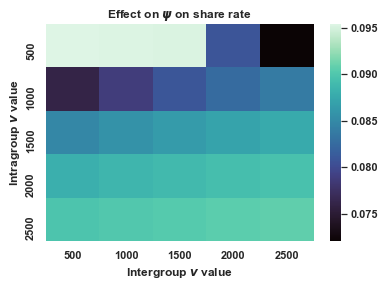

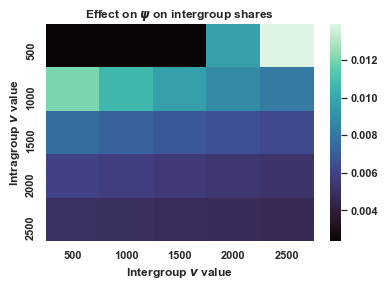

In [29]:
import seaborn as sns 
print(data_psi)

sns.set()
ax = sns.heatmap(data_psi,cmap='mako', xticklabels=[np.round(x,2) for x in np.arange(rng_min, rng_max, step=st)], yticklabels=[np.round(x,2) for x in np.arange(rng_min, rng_max, step=st)])
plt.title("Effect on $\\psi$ on share rate")
plt.xlabel("Intergroup $v$ value")
plt.ylabel("Intragroup $v$ value")
plt.savefig('../figures/' + str(dataset_name) + '_heatmap_psi.pdf')
plt.show()



sns.set()
ax = sns.heatmap(ig_data_psi,cmap="mako", xticklabels=[np.round(x,2) for x in np.arange(rng_min, rng_max, step=st)], yticklabels=[np.round(x,2) for x in np.arange(rng_min, rng_max, step=st)])
plt.title("Effect on $\\psi$ on intergroup shares")
plt.xlabel("Intergroup $v$ value")
plt.ylabel("Intragroup $v$ value")
plt.savefig('../figures/' + str(dataset_name) + '_heatmap_psi_intergroup.pdf')
plt.show()
